<a href="https://colab.research.google.com/github/pareshrchaudhary/colab/blob/main/homework/hw_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AA/EE/ME 548: Homework 03

## Name: Paresh Chaudhary 

### Export page instructions:
Export the PDF as though you were going to print the page in your browser (Ctrl+P) rather than through Colab's print functionality, otherwise some of the text will be cut off.

### Homework feedback:

**What was the coolest thing(s) you learned from lectures/homework that you didn't know previously?**



**Which problem did you find the most challenging and why?**



**Approximate how long did you spend on this homework?**


**Feedback on this homework (can improve for future hw and years)**


## Submission details
To submit your homework, please save a PDF copy of your notebook (make sure all the cells are run correctly, and the correct outputs are displayed), and submit via Canvas.

In [1]:
import jax
import jax.numpy as jnp
from jax import jit, jacrev, jacfwd, lax
import numpy as np
from jax.typing import ArrayLike
import matplotlib.pyplot as plt

## Problem 1

### (a)

If we add a cross term $S_k = 2x_k^TS_ku_k$ to the cost-to-go such that $S_k \in \mathbb{R}^{n \times m}$ and $\begin{bmatrix} Q_k & S_k \\ S_k^T & R_k \end{bmatrix} \geq 0$ for $K = 0, \dots, N-1$, the update equation for $P_k$ and the gain $K_k$ with the cross term present would be as follows:
\
The value function satisfies the following Bellman equation:
\
\
$$V_N(x) = x^T Q_N x$$
\
\
$$V_{N-1}(x) = \min_{u} \left\{ x^T Q x + u^T R u + 2x^TSu + V_{N}(x) \right\}$$
\
\
To solve for the optimal control sequence, we can work backwards from time $N$ to time $0$. At time $N$, we have:
\
\
$$V_N(x) = x^T Q_N x$$

At time $N-1$, we have:

$$V_{N-1}(x) = \min_{u} \left\{ x^T Q x + u^T R u + 2x^TSu + V_{N}(Ax + Bu) \right\}$$
\
\
$$= \min_{u} \left\{ x^T Q x + u^T R u + 2x^TSu + (Ax + Bu)^T Q_N (Ax + Bu) \right\}$$
\
\
$$= \min_{u} \left\{ x^T Q x + u^T R u + 2x^TSu  + x^T A^T Q_N Ax + x^T A^T Q_N Bu + u^T B^T Q_N Ax + u^T B^T Q_N Bu \right\}$$
\
\
$$= \min_{u} \left\{ x^T Q x + x^T A^T Q_N Ax  + u^T R u + 2x^TSu + x^T A^T Q_N Bu + u^T B^T Q_N Ax + u^T B^T Q_N Bu \right\}$$
\
\
$$= x^T Q x + x^T A^T Q_N Ax + \min_{u} \left\{ (u^T R u + u^T B^T Q_N Bu + 2x^TSu + x^T A^T Q_N Bu + u^T B^T Q_N Ax )\right\}$$
\
\
The optimal control input at time $N-1$ is given by:
\
\
$$2Ru + 2B^T Q_N Bu + 2x^TS + 2A^T Q_N Bx = 0$$
\
$$u_{N-1} = -(R + B^TQB)^{-1}(B^TQ_NA + S)x$$
\
where $P_N = Q_N$. This process can be repeated for all previous time steps until we reach time $0$. The resulting optimal control sequence is given by:
\begin{equation}
\boxed{\boxed{u_k = - (R+B^TP_{k+1}B)^{-1}(B^TP_{k+1}A+S)x}}
\end{equation}
$$u_k = - (K_k)x.$$
\
We can further simplify this expression by defining the feedback gain matrix $K_k$ as:
\
\
\begin{equation}
\boxed{\boxed{K_k = -(R+B^TP_{k+1}B)^{-1}(B^TP_{k+1}A+S)}}
\end{equation}
\
\
Substituting this back into the expression for $V_{K-1}(x)$, we get:
\
\
$$V_{N-1}(x) = \min_{u} \left\{ x^T Q x + [-K_kx]^T R [-K_kx] + 2x^TS[-K_kx] + (Ax + B[-K_kx])^T Q_N (Ax + B[-K_kx]) \right\}$$
\
$$V_{N-1}(x) = \min_{u} \left\{ x^T Q x + -x^T K^T R K x + -2x^TSK_kx + x^T(A^TQ_NA - A^TQ_NBK - K^TB^TQ_NA + K^TB^TQ_NBK)x \right\}$$
\
$$V_{N-1}(x) = \min_{u} \left\{ x^T(Q - K^TRK - 2SK + A^TQ_NA - A^TQ_NBK - K^TB^TQ_NA + K^TB^TQ_NBK)x \right\}$$
\
The value function is simplified by defining the matrix $P_k$ recursively as:
\
\
\begin{equation}
\boxed{\boxed{P_k = (Q - K^TRK - 2SK + A^TQ_NA - A^TQ_NBK - K^TB^TQ_NA + K^TB^TQ_NBK)}}
\end{equation}

# Problem 2

See separate notebook

# Problem 3

In [ ]:
!pip install --upgrade hj-reachability

In [3]:
from IPython.display import HTML
import matplotlib.animation as anim
import plotly.graph_objects as go

import hj_reachability as hj
from hj_reachability import dynamics
from hj_reachability import sets

In [4]:
class DynUnicycle(dynamics.ControlAndDisturbanceAffineDynamics):

    def __init__(self,
                 max_turn_rate=1.,
                 max_accel=2.,
                 control_mode="max",
                 disturbance_mode="min",
                 control_space=None,
                 disturbance_space=None,
                 alpha=0.):
        # control and disturbance bounds
        # in this set up, the disturbance bounds are proportional to the control
        # bounds by a factor of alpha
        if control_space is None:
            control_space = sets.Box(lo=jnp.array([-max_turn_rate, -max_accel]), hi=jnp.array([max_turn_rate, max_accel]))
        if disturbance_space is None:
            disturbance_space = sets.Box(lo=jnp.array([-max_turn_rate * alpha, -max_accel * alpha]), hi=jnp.array([max_turn_rate * alpha, max_accel * alpha]))
        super().__init__(control_mode, disturbance_mode, control_space, disturbance_space)

    def open_loop_dynamics(self, state, time):
        _, _, theta, v_a  = state
        return jnp.array([v_a * jnp.cos(theta), v_a * jnp.sin(theta), 0, 0])

    def control_jacobian(self, state, time):
        x, y, _, _= state
        return jnp.array([
            [0., 0.],
            [0., 0.],
            [1., 0.],
            [0., 1.],
        ])

    def disturbance_jacobian(self, state, time):
        return jnp.array([
            [0., 0.],
            [0., 0.],
            [1., 0.],
            [0., 1.],
        ])


In [5]:
### REACH ###
# control_mode = "min"
# disturbance_mode = "max"
####################################

### AVOID or when computing FRS ###
control_mode = "max"
disturbance_mode = "min"
####################################

# model with noise/disturbance bounds proportional to the control limits
dynamics_noisy = DynUnicycle(alpha=0.6, control_mode=control_mode, disturbance_mode=disturbance_mode)

# no noise on the model
dynamics = DynUnicycle(control_mode=control_mode, disturbance_mode=disturbance_mode)

grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(lo=np.array([-10., -10., 0., -4.]),
                                                                   hi=np.array([10., 10., 2 * np.pi, 4.])), (21, 21, 30, 31),
                                                       periodic_dims=2)
# terminal values. circle in position space centered at origin and with radius 3
values = jnp.linalg.norm(grid.states[..., :2], axis=-1) - 3
solver_settings = hj.SolverSettings.with_accuracy("very_high",
                                                  hamiltonian_postprocessor=hj.solver.backwards_reachable_tube)

In [6]:
# solve the HJI equation
time = 0.
target_time = -2  
target_values = hj.step(solver_settings, dynamics, grid, time, values, target_time).block_until_ready()
target_values_noisy = hj.step(solver_settings, dynamics_noisy, grid, time, values, target_time).block_until_ready()


100%|##########|  2.0000/2.0 [00:14<00:00,  7.00s/sim_s]
100%|##########|  2.0000/2.0 [00:13<00:00,  6.67s/sim_s]


<Figure size 640x480 with 0 Axes>

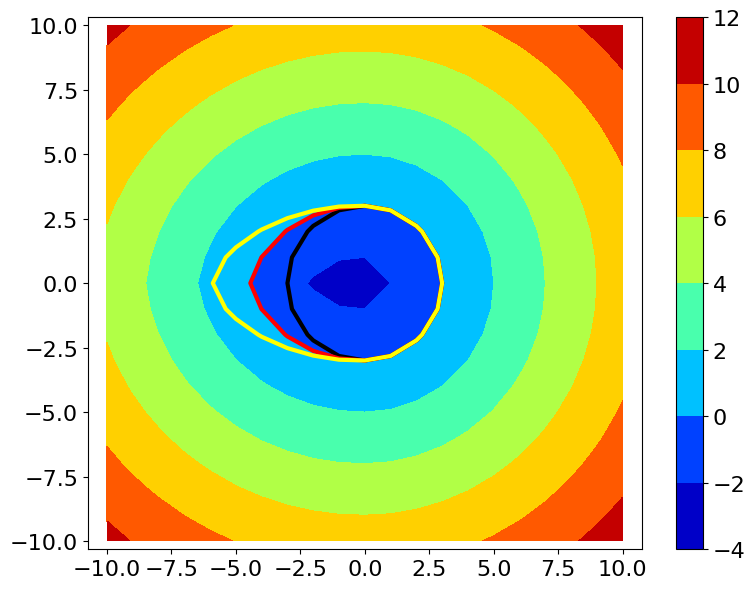

In [7]:
## plotting
fontsize = 16
## When plotting, use the following indices for theta and v when 
## slicing the value function across the x and y dimensions.
theta_i = 0
v_i = 25

plt.jet()
plt.figure(figsize=(8, 6))
plt.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1], target_values[:, :, theta_i, v_i].T)
cbar = plt.colorbar()
plt.contour(grid.coordinate_vectors[0],
            grid.coordinate_vectors[1],
            values[:, :, theta_i, v_i].T,
            levels=0,
            colors="black",
            linewidths=3)
plt.contour(grid.coordinate_vectors[0],
            grid.coordinate_vectors[1],
            target_values[:, :, theta_i, v_i].T,
            levels=0,
            colors="red",
            linewidths=3)
plt.contour(grid.coordinate_vectors[0],
            grid.coordinate_vectors[1],
            target_values_noisy[:, :, theta_i, v_i].T,
            levels=0,
            colors="yellow",
            linewidths=3)



plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
ticklabs = cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(ticklabs, fontsize=fontsize)
plt.axis("equal")
plt.tight_layout() 

# Problem 4

## 4(a) 

We have -
$$\underset{\substack{\text{$\dot{z}$}}}{\underbrace{\begin{bmatrix} \dot{p_x}\\\dot{p_y} \\\dot{v_x} \\\dot{v_y} \end{bmatrix} }}
 = \underset{\substack{\text{A}}}{\underbrace{\begin{bmatrix} 0&0&1&0 \\ 0&0&0&1 \\ 0&0&0&0 \\ 0&0&0&0 \end{bmatrix}}}
\underset{\substack{\text{$z$}}}{\underbrace{\begin{bmatrix} p_x\\p_y \\v_x\\v_y \end{bmatrix}}}
 + \underset{\substack{\text{B}}}{\underbrace{\begin{bmatrix} 0&0 \\ 0&0 \\ 1&0 \\ 0&1 \end{bmatrix}}}
 \underset{\substack{\text{$u$}}}{\underbrace{\begin{bmatrix} a_x \\ a_y  \end{bmatrix}}} =
 \underset{\substack{\text{$Az+Bu$}}}{\underbrace{\begin{bmatrix} v_x \\ v_y \\ a_x \\ a_y \end{bmatrix}}}$$
 
\
\
Using ZOH method to discretize the model we can formulate-

$$z_{k+1} = e^{AΔt}z_k + \int_{0}^{\Delta t} e^{A(\Delta t - τ)}Bu(τ)dτ$$
\
\
$$z_{k+1} = e^{AΔt}(z_k + \int_{0}^{\Delta t} e^{-Aτ}Bu(τ)dτ)$$
\
\
Now using Taylor series expansion,
\
\
$$e^{AΔt} = I + A\Delta t + \frac{1}{2}A^2Δt^2+....$$

As Δt is very small, we can ignore terms from $\frac{1}{2}A^2Δt^2 + ....$,
\
\
$$e^{AΔt} = \begin{bmatrix} 1&0&Δt&0 \\ 0&1&0&Δt \\ 0&0&1&0 \\ 0&0&0&1 \end{bmatrix}$$
\
\
$$e^{-Aτ} = \begin{bmatrix} 1&0&-τ&0 \\ 0&1&0&-τ \\ 0&0&1&0 \\ 0&0&0&1 \end{bmatrix}$$
\
\
Plugging values in $z_{k+1}$,
\
\
$$z_{k+1} = e^{AΔt}(z_k + \int_{0}^{\Delta t} \begin{bmatrix} 1&0&-τ&0 \\ 0&1&0&-τ \\ 0&0&1&0 \\ 0&0&0&1 \end{bmatrix} \begin{bmatrix} 0&0 \\ 0&0 \\ 1&0 \\ 0&1 \end{bmatrix} \begin{bmatrix} a_x \\ a_y  \end{bmatrix} dτ)$$
\
\
$$z_{k+1} = e^{AΔt}(z_k + \int_{0}^{\Delta t} \begin{bmatrix} 1&0&-τ&0 \\ 0&1&0&-τ \\ 0&0&1&0 \\ 0&0&0&1 \end{bmatrix} \begin{bmatrix} 0 \\ 0 \\ a_x \\ a_y \end{bmatrix}dτ)$$
\
\
$$z_{k+1} = e^{AΔt}(z_k + \int_{0}^{\Delta t} \begin{bmatrix} -a_xτ \\ -a_yτ \\ a_x \\ a_y \end{bmatrix}dτ)$$
\
\
$$z_{k+1} = e^{AΔt}(z_k + \begin{bmatrix} -\frac{1}{2} a_xτ^2 \\ -\frac{1}{2}a_yτ^2 \\ a_xτ \\ a_yτ \end{bmatrix}_{0}^{\Delta t})$$
\
\
$$z_{k+1} = e^{AΔt}(z_k + \begin{bmatrix} -\frac{1}{2} a_x\Delta t^2 \\ -\frac{1}{2}a_y\Delta t^2 \\ a_x\Delta t \\ a_y\Delta t \end{bmatrix})$$
\
\
$$z_{k+1} = e^{AΔt}z_k + e^{AΔt}\begin{bmatrix} -\frac{1}{2} a_x\Delta t^2 \\ -\frac{1}{2}a_y\Delta t^2 \\ a_x\Delta t \\ a_y\Delta t \end{bmatrix}$$
\
\
$$z_{k+1} = \begin{bmatrix} 1&0&Δt&0 \\ 0&1&0&Δt \\ 0&0&1&0 \\ 0&0&0&1 \end{bmatrix}z_k + \begin{bmatrix} 1&0&Δt&0 \\ 0&1&0&Δt \\ 0&0&1&0 \\ 0&0&0&1 \end{bmatrix}\begin{bmatrix} -\frac{1}{2} a_x\Delta t^2 \\ -\frac{1}{2}a_y\Delta t^2 \\ a_x\Delta t \\ a_y\Delta t \end{bmatrix}$$
\
\
$$z_{k+1} = \begin{bmatrix} 1&0&Δt&0 \\ 0&1&0&Δt \\ 0&0&1&0 \\ 0&0&0&1 \end{bmatrix}z_k + \begin{bmatrix} \frac{1}{2} a_x\Delta t^2 \\ \frac{1}{2} a_y\Delta t^2 \\ a_x\Delta t \\ a_y\Delta t \end{bmatrix}$$
\
\
$$\boxed{z_{k+1} = {\begin{bmatrix} 1&0&Δt&0 \\ 0&1&0&Δt \\ 0&0&1&0 \\ 0&0&0&1 \end{bmatrix}}
\text{$z_k$} + 
{\begin{bmatrix} \frac{1}{2} \Delta t^2 & 0 \\ 0 & \frac{1}{2}\Delta t^2 \\ \Delta t & 0 \\ 0 & \Delta t \end{bmatrix}}
{{\begin{bmatrix} a_x \\ a_y \end{bmatrix}}}}$$

## 4(b)

The trajectory optimization problem can be formulated as follows:

\begin{aligned}
\text{minimize} \quad & \sum_{k=0}^{T-1} \|u_k\|_2^2 \\
\text{subject to} \quad & x_{k+1} = f(x_k, u_k), \quad \forall k = 0, 1, \ldots, T-1 \\
& x_0 = x_{\text{start}}, \quad x_T = x_{\text{final}} \\
& \|u_k\|_2 \leq a_{\text{max}}, \quad \forall k = 0, 1, \ldots, T-1 \\
& x_k \text{ satisfies state constraints}, \quad \forall k = 0, 1, \ldots, T \\
& u_k \text{ satisfies control constraints}, \quad \forall k = 0, 1, \ldots, T-1 \\
\end{aligned}


In this formulation, the objective function minimizes the sum of the squared magnitudes of accelerations over the time steps. The dynamics constraints represent the system dynamics, where $f(x_k, u_k)$ is the function describing the evolution of the state from time step $(k)$ to $(k+1)$ based on the control input $(u_k)$. The initial and final states are enforced as constraints. The constraint $||u_k\|_2 \leq a_{\text{max}}$ ensures that the magnitude of the control input remains within the maximum acceleration bounds. The state and control constraints can include bounds on position, velocity, and other variables based on the specific problem requirements.

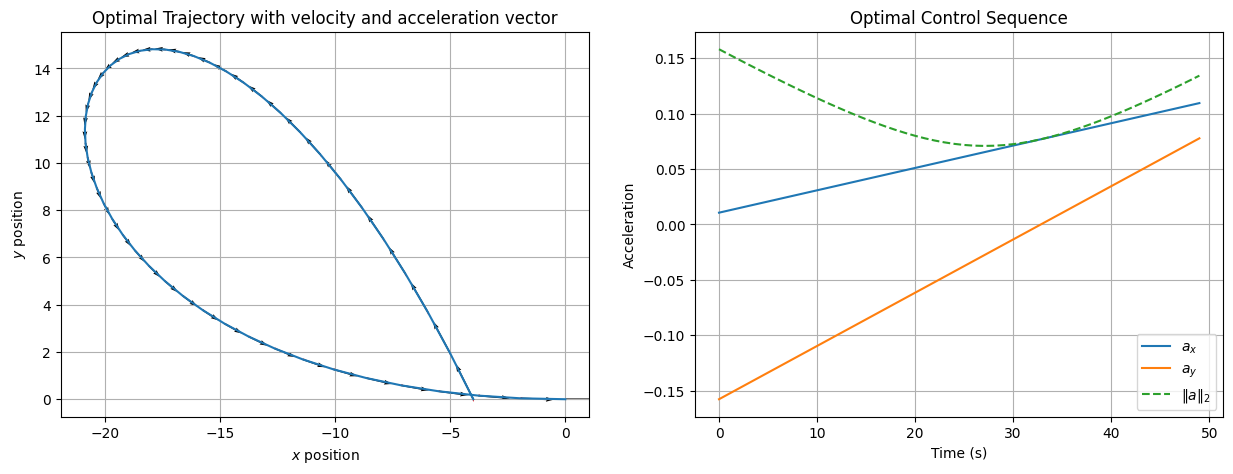

In [10]:
import cvxpy as cp


T = 50  # number of time steps
n = 4   # state dimension
m = 2   # control dimension

xs = cp.Variable([T+1,n]) # state trajectory variable
us = cp.Variable([T,m])   # control trajectory variable

### Add your code here
a_max = 2 # acc constraint
dt = 1

x_initial = np.array([-4,0,-1,2])
x_final = np.array([0,0,2,0])

A = np.matrix([[1,0,dt,0],
              [0,1,0,dt],
              [0,0,1,0],
              [0,0,0,1]])

B = np.array([[0.5*dt*dt, 0],
             [0,0.5*dt*dt],
             [dt,0],
             [0,dt]])

cost = cp.sum_squares(us)
constr = []
for t in range(T):
    cost += cp.sum_squares(us[t,:])
    constr += [xs[t + 1,:] == A @ xs[t,:] + B @ us[t,:], cp.norm2(us[t,:]) <= a_max]
# sums problem objectives and concatenates constraints.
constr += [xs[T,:] == x_final, xs[0,:] == x_initial]
problem = cp.Problem(cp.Minimize(cost), constr)
problem.solve()

######################



# plotting out results.
states = xs.value 
controls = us.value

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(states[:,0], states[:,1])
plt.quiver(states[:,0], states[:,1], states[:,2], states[:,3], scale=30, width=.003)
plt.quiver(states[:-1,0], states[:-1,1], controls[:,0], controls[:,1], scale=30, width=.003, color='red')
plt.title("Optimal Trajectory with velocity and acceleration vector")
plt.xlabel("$x$ position")
plt.ylabel("$y$ position")
plt.grid()

plt.subplot(1,2,2)
plt.plot(controls)
plt.plot(np.linalg.norm(controls, 2, axis=1), '--')
plt.title("Optimal Control Sequence")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration")
plt.legend(["$a_x$", "$a_y$", "$\|a\|_2$"])
plt.grid()